In [1]:
import os
import pysal as ps 
import pandas as pd 
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal.lib
import pysal.explore
import pysal.viz
import pysal.model

C:\Users\jwolf\AppData\Local\conda\conda\envs\pandas\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
os.chdir('C:/Users/jwolf/Documents/MEGA/03_Doutoramento/06_Base de dados/School closure')

In [3]:
path = "C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Administrativos/Municípios/Cont_AAD_CAOP2018/\
Cont_AAD_CAOP2018.shp"
gdf_freguesias_CAOP2018 = gpd.read_file (path)
gdf_freguesias_CAOP2018['code_mun'] = gdf_freguesias_CAOP2018['Dicofre'].str.slice(0,4)

In [4]:
df_correspond_nuts3 = pd.read_csv("CODIGOS_MUNICIPIOS_NUTS3.csv",engine='python', header = 0,\
                                  sep = ";",dtype= {'Cod_mun': str}, decimal=",")
df_correspond_nuts3.dropna(inplace = True)

In [5]:
# pd.merge(gdf_freguesias_CAOP2018, df_correspond_nuts3, how = left,  left_on = "code_mun")
gdf_freguesias_CAOP2018= pd.merge(gdf_freguesias_CAOP2018, df_correspond_nuts3, how='left', left_on = "code_mun",right_on= "Cod_mun")
gdf_freguesias_CAOP2018.drop(['Cod_mun'], axis=1, inplace = True)

In [6]:
#3763 código epsg etrs89 e Portugal TM06
#WGS84 = epsg 4326

gdf_freguesias_CAOP2018 = gdf_freguesias_CAOP2018.to_crs(epsg=3763)

In [7]:
gdf_municipios_CAOP2018 = gdf_freguesias_CAOP2018.dissolve(by='code_mun')
gdf_municipios_CAOP2018.drop(['Dicofre','Freguesia', 'Des_Simpli', 'TAA'], axis = 1, inplace = True)

In [8]:
df_schools = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/Schools.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'Code': str}, decimal=",")
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_schools, how='left', left_on=['code_mun'],\
                                   right_on = ['Code'])

In [9]:
l = []
l = list(gdf_municipios_CAOP2018.columns[:9]) + \
["Escolas_" + s  for s in gdf_municipios_CAOP2018.columns[9:24].str.slice(0,4)] +\
list(gdf_municipios_CAOP2018.columns[24:])

gdf_municipios_CAOP2018.columns = l

In [10]:
#gdf_municipios_CAOP2018.columns.get_loc('TX_99_17')

In [11]:
df_TFR = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/ISF_2017_pivot.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'Code': str}, decimal=",")
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_TFR, how='left', left_on=['Code'],\
                                   right_on = ['code'])

In [12]:
l = []
l = list(gdf_municipios_CAOP2018.columns[0:26]) + ["TFR_" + s  for s in gdf_municipios_CAOP2018.columns[26:53]]
gdf_municipios_CAOP2018.columns = l


In [13]:
df_Migration = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/MIGRANTS_pivot.csv",\
                         engine='python', header = 0, sep = ";",dtype= {'code': str}, decimal=",")

In [14]:
df_Migration.head(3)
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_Migration, how='left', left_on=['Code'],\
                                   right_on = ['code'])

In [15]:
l = []
l = list(gdf_municipios_CAOP2018.columns[:54]) + ["MIGR_" + s  for s in gdf_municipios_CAOP2018.columns[54:]]
gdf_municipios_CAOP2018.columns = l


In [16]:
col_names = pd.read_csv('C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/Primary_Schools_FDM.csv',\
                        nrows=0).columns
col_names
types_dict = {'Code': str}
types_dict.update({col: str for col in col_names if col not in types_dict})

df_Schools_FDM = pd.read_csv("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/05_SIG/Muhamad/Primary_Schools_FDM.csv",\
                         engine='python', sep = ";",dtype=types_dict, decimal=",", header=0)

df_Schools_FDM

,Code,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0101,0.450269,0.455058,0.436902,0.442898,0.451016,0.461850,0.476217,0.372917,0.198623,0.223451,2.138100e-01,2.494450e-01,2.993338e-01,3.741674e-01,4.485693e-01,4.222729e-01,2.076383e-01
1,0102,0.448421,0.375180,0.400192,0.401651,0.404574,0.409398,0.416726,0.373741,0.369910,0.265926,3.039160e-01,3.545685e-01,3.053820e-01,4.770000e-07,7.150000e-07,9.540000e-07,1.910000e-06
2,0103,0.555039,0.589729,0.629044,0.650933,0.677335,0.709435,0.748849,0.687759,0.463854,0.211051,2.412007e-01,2.271273e-01,2.140045e-01,2.675056e-01,3.566742e-01,-9.540000e-07,-1.910000e-06
3,0104,0.672697,0.692833,0.739022,0.763537,0.793084,0.828996,0.873099,0.488514,0.502385,0.522725,5.974002e-01,4.477973e-01,4.788084e-01,6.003190e-02,8.004240e-02,-2.380000e-07,-4.770000e-07
4,0105,0.167202,0.130423,0.139118,0.149054,0.160520,0.173897,0.189706,0.233396,0.100328,0.083647,9.559630e-02,8.041600e-02,9.649920e-02,1.492740e-02,1.990320e-02,-1.492450e-02,-2.984930e-02
5,0106,0.358838,0.343981,0.366913,0.354156,0.340755,0.326662,0.311826,0.196124,0.106711,0.120050,1.372004e-01,1.600671e-01,1.271999e-01,1.589999e-01,2.840893e-01,7.155080e-02,1.431017e-01
6,0107,0.235235,0.310668,0.331379,0.340064,0.350947,0.364604,0.381824,0.420007,0.327604,0.368555,4.949634e-01,3.352115e-01,4.022536e-01,5.028172e-01,6.704228e-01,7.707540e-02,1.541508e-01
7,0108,0.271408,0.288371,0.307596,0.329567,0.354918,0.384495,0.419449,0.401920,0.243998,0.274498,3.137114e-01,3.659966e-01,4.391959e-01,5.489950e-01,3.184533e-01,-7.150000e-07,-1.430000e-06
8,0109,0.197278,0.197737,0.210919,0.219949,0.230766,0.243824,0.259738,0.207108,0.243753,0.246442,2.379670e-01,1.992993e-01,1.880875e-01,1.795449e-01,1.343515e-01,1.869270e-02,9.540000e-07
9,0110,0.111769,0.069328,0.073949,0.079231,0.085326,0.092437,0.100840,0.057255,0.063616,0.013863,1.584390e-02,7.832670e-02,3.244020e-02,4.055020e-02,5.406690e-02,-4.770000e-07,-9.540000e-07


In [17]:
l = []
l = ["Schools_FDM" + s  for s in df_Schools_FDM.columns[0:]]
df_Schools_FDM.columns = l 
gdf_municipios_CAOP2018 = pd.merge(gdf_municipios_CAOP2018, df_Schools_FDM, how='left', left_on=['Code'],\
                                  right_on = ['Schools_FDMCode'])

In [18]:
def Local_moran_I (l, matrizes): 
    a = {}
    for i in l:
        key = str(i)
        value = pysal.explore.esda.Moran_Local\
        (gdf_municipios_CAOP2018[i], matrizes[1], transformation='r', permutations=999)
        a[key] = (matrizes[0],value)
    return(a)

In [19]:
n_vizinhos = 3
distancia=30000
matrizes = []
matrizes = [("Queen "+str(n_vizinhos)+" neighbours"),\
            pysal.lib.weights.KNN.from_dataframe(gdf_municipios_CAOP2018, k= n_vizinhos)]

#[("Distance "+str(distancia//1000)+'km'),\
#pysal.lib.weights.DistanceBand.from_dataframe(gdf_municipios_CAOP2018, \
#p = 2, alpha=-3, threshold= distancia)] 

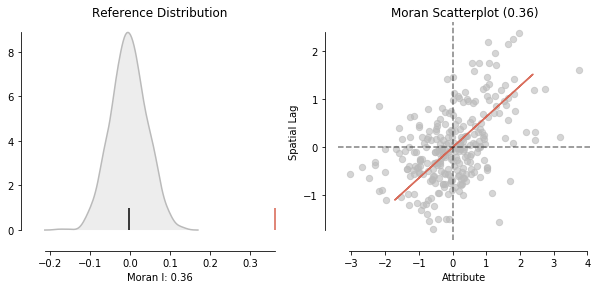

In [20]:
from pysal.explore.esda.moran import Moran
from pysal.viz.splot.esda import plot_moran
l = ['MIGR_1999','MIGR_2017',
    'TFR_1999','TFR_2017']

moran_I = pysal.explore.esda.Moran(gdf_municipios_CAOP2018['TFR_2017'], matrizes[1], transformation='r', permutations=999)
# print("p value =", moran_I.p_norm, "Moran I = ", moran_I.I,"expected value under normality assumption", moran_I.EI) 
plot_moran(moran_I)
plt.show()

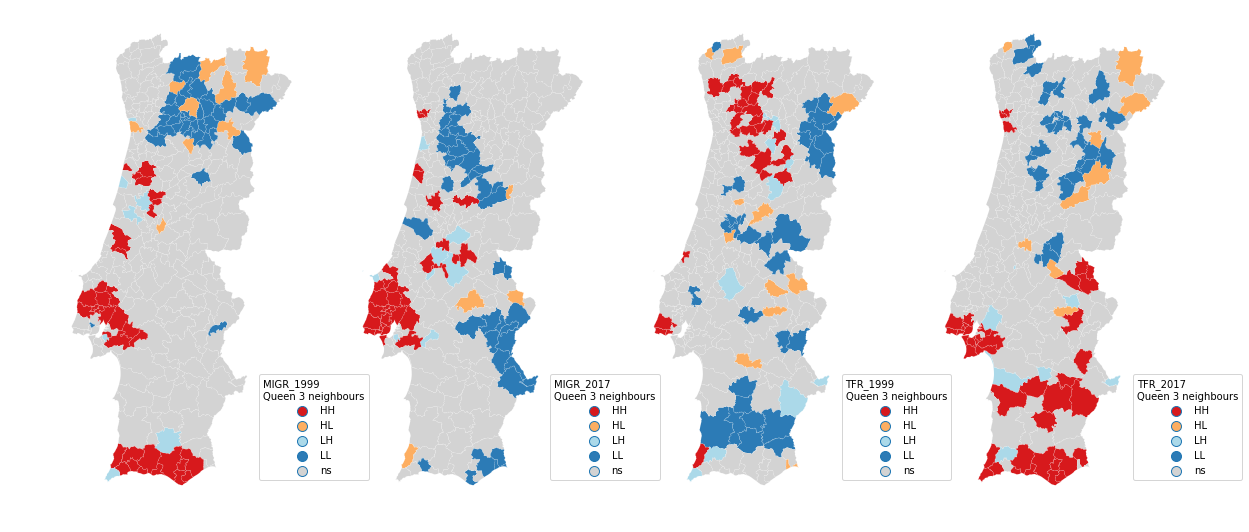

In [35]:
from pysal.viz.splot.esda import lisa_cluster


l = ['MIGR_1999','MIGR_2017',
    'TFR_1999','TFR_2017']
    #'TX_99_17', 'TFR_1997','TFR_2017'
a = Local_moran_I(l, matrizes)
             
fig, axs = plt.subplots(1,len(a),figsize = (20,20))

i=0 
for x, value in dict.items(a):
    legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
    'title': x + '\n'+ value[0]}
    lisa_cluster(value[1], gdf_municipios_CAOP2018.copy(), p=0.1, ax = axs [i], \
    legend_kwds= legenda)
    i+=1
plt.savefig("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/08_Apresentações_publicações/\
Muhammad/TFR_MIGR.png", dpi=600,  bbox_inches="tight")

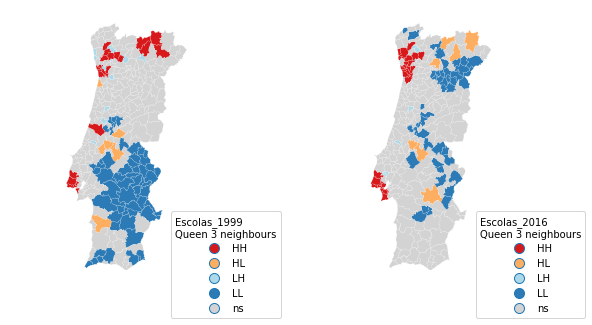

In [22]:
l = ['Escolas_1999', 'Escolas_2016']
a = Local_moran_I(l, matrizes)
             
fig, axs = plt.subplots(1,len(a),figsize = (10,5))

i=0 
for x, value in dict.items(a):
    legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
    'title': x + '\n'+ value[0]}
    lisa_cluster(value[1], gdf_municipios_CAOP2018.copy(), p=0.1, ax = axs [i], \
    legend_kwds= legenda)
    i+=1


In [23]:
df_Schools_FDM.head(3)

,Schools_FDMCode,Schools_FDM1999,Schools_FDM2000,Schools_FDM2001,Schools_FDM2002,Schools_FDM2003,Schools_FDM2004,Schools_FDM2005,Schools_FDM2006,Schools_FDM2007,Schools_FDM2008,Schools_FDM2009,Schools_FDM2010,Schools_FDM2011,Schools_FDM2012,Schools_FDM2013,Schools_FDM2014,Schools_FDM2015
0,0101,0.450269,0.455058,0.436902,0.442898,0.451016,0.461850,0.476217,0.372917,0.198623,0.223451,0.213810,0.249445,0.299334,3.741674e-01,4.485693e-01,4.222729e-01,0.207638
1,0102,0.448421,0.375180,0.400192,0.401651,0.404574,0.409398,0.416726,0.373741,0.369910,0.265926,0.303916,0.354569,0.305382,4.770000e-07,7.150000e-07,9.540000e-07,0.000002
2,0103,0.555039,0.589729,0.629044,0.650933,0.677335,0.709435,0.748849,0.687759,0.463854,0.211051,0.241201,0.227127,0.214004,2.675056e-01,3.566742e-01,-9.540000e-07,-0.000002


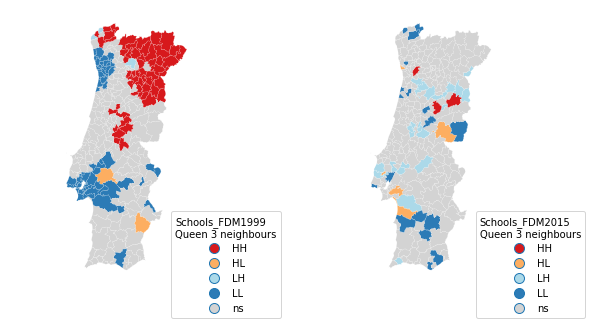

In [36]:
l = ['Schools_FDM1999', 'Schools_FDM2015']
a = Local_moran_I(l, matrizes)
            
fig, axs = plt.subplots(1,len(a),figsize = (10,5))
i=0 

for x, value in dict.items(a):
    legenda = {'loc': 'upper left', 'bbox_to_anchor': (0.8, 0.28),\
    'title': x + '\n'+ value[0]}
    lisa_cluster(value[1], gdf_municipios_CAOP2018.copy(), p=0.1, ax = axs [i], \
    legend_kwds= legenda)
    i+=1

plt.savefig("C:/Users/jwolf/Documents/MEGA/03_Doutoramento/08_Apresentações_publicações/\
Muhammad/Primary_Schools_FDM.png", dpi=600,  bbox_inches="tight")

In [25]:
gdf_municipios_CAOP2018.head(2)

,geometry,Concelho,Distrito,AREA_EA_Ha,AREA_T_Ha,NUTS3_2016,NUTS_nome,Code,Name,Escolas_1999,...,Schools_FDM2006,Schools_FDM2007,Schools_FDM2008,Schools_FDM2009,Schools_FDM2010,Schools_FDM2011,Schools_FDM2012,Schools_FDM2013,Schools_FDM2014,Schools_FDM2015
0,POLYGON ((-14839.47989999963 103073.8716999997...,ÁGUEDA,AVEIRO,1019.01,1019.01,16D,Região de Aveiro,0101,Águeda,46,...,0.372917,0.198623,0.223451,0.213810,0.249445,0.299334,3.741674e-01,4.485693e-01,4.222729e-01,0.207638
1,POLYGON ((-29041.31800000001 108973.6844999988...,ALBERGARIA-A-VELHA,AVEIRO,1535.86,1535.86,16D,Região de Aveiro,0102,Albergaria-a-Velha,33,...,0.373741,0.369910,0.265926,0.303916,0.354569,0.305382,4.770000e-07,7.150000e-07,9.540000e-07,0.000002
